In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
df = pd.read_csv('2021_Green_Taxi_Trip_Data.csv')


C:\Users\mobin\AppData\Local\Temp\ipykernel_18140\3237524167.py:19: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('2021_Green_Taxi_Trip_Data.csv')


In [35]:

irrelevant_columns = ['RatecodeID', 'store_and_fwd_flag', 'improvement_surcharge',
                      'ehail_fee', 'mta_tax', 'extra', 'fare_amount',
                      'congestion_surcharge']
df = df.drop(irrelevant_columns, axis=1)
df.info()
df=df.drop_duplicates()
df = df[(df.trip_distance >= 0) & (df.tip_amount >= 0) & (df.tolls_amount >= 0) & (df.total_amount >= 0)]
df['payment_type'] = df['payment_type'].astype(object)
df['trip_type'] = df['trip_type'].astype(object)


df.loc[(df['tip_amount'] > 0) & (df['payment_type'].isnull()), 'payment_type'] = 1
df.loc[df['passenger_count'] > 4, 'payment_type'] = 6
df.loc[df['passenger_count'] > 4, 'trip_type'] = 3
df.dropna(subset=['VendorID'], inplace=True)
df['pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df = df[df['pickup_datetime'].dt.year == 2021]
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
print(missing_value_df)

df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_month'] = df['pickup_datetime'].dt.month
df['weekday'] = df['pickup_datetime'].dt.day_name()
weekday_mapping = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}
# Apply the mapping to the 'weekday' column
df['weekday'] = df['weekday'].map(weekday_mapping)


df['dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df['dropoff_hour'] = df['dropoff_datetime'].dt.hour
df['dropoff_day'] = df['dropoff_datetime'].dt.day
df['dropoff_month'] = df['dropoff_datetime'].dt.month


df.drop(columns=['lpep_pickup_datetime', 'lpep_dropoff_datetime'], inplace=True)
borough_df = pd.read_csv('Boroughs.csv')
df = df.merge(borough_df[['LocationID', 'Borough']], left_on='PULocationID', right_on='LocationID', how='left')
df.rename(columns={'Borough': 'PU_Borough'}, inplace=True)

df = df.merge(borough_df[['LocationID', 'Borough']], left_on='DOLocationID', right_on='LocationID', how='left')
df.rename(columns={'Borough': 'DO_Borough'}, inplace=True)
df = pd.get_dummies(df, columns=['PU_Borough','DO_Borough'], prefix=['PU','DO'], drop_first=True)
df.drop([ 'PULocationID', 'DOLocationID', 'pickup_datetime', 'dropoff_datetime' ,], axis=1, inplace=True)
print(df.columns)
df = df.apply(pd.to_numeric, errors='coerce')
for column in df.columns:
    null_percentage = df[column].isnull().mean()
    if 0.05 < null_percentage <= 0.3:
        missing_rows = df[df[column].isnull()]
        complete_rows = df[df[column].notnull()]

        features_to_drop = [column]
        if complete_rows[column].dtype in ['int64', 'float64']:
            model = HistGradientBoostingRegressor()
            model.fit(complete_rows.drop(columns=features_to_drop, errors='ignore'), complete_rows[column])
            predicted_values = model.predict(missing_rows.drop(columns=features_to_drop, errors='ignore'))
            df.loc[df[column].isnull(), column] = predicted_values


        else:
            model = HistGradientBoostingClassifier()
            model.fit(complete_rows.drop(columns=features_to_drop, errors='ignore'), complete_rows[column])
            predicted_values = model.predict(missing_rows.drop(columns=features_to_drop, errors='ignore'))
            df.loc[df[column].isnull(), column] = predicted_values

print(df.LocationID_x.head())
print(df.LocationID_y.head())
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
print(missing_value_df)

df['PU_Bronx'] = (df.filter(like='PU_').sum(axis=1) == 0).astype(int)

df['DO_Bronx'] = (df.filter(like='DO_').sum(axis=1) == 0).astype(int)
# Create OD matrix
od_matrix = pd.DataFrame(index=df.columns[df.columns.str.startswith('PU_')],
                         columns=df.columns[df.columns.str.startswith('DO_')]).fillna(0)
for pu_col in df.columns[df.columns.str.startswith('PU_')]:
    for do_col in df.columns[df.columns.str.startswith('DO_')]:
        od_matrix.loc[pu_col, do_col] = df[(df[pu_col] == 1) & (df[do_col] == 1)].shape[0]

# Calculate sums for origins and destinations
od_matrix.loc['Total'] = od_matrix.sum()  # Sum for each drop-off column
od_matrix['Total'] = od_matrix.sum(axis=1)  # Sum for each pickup row


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068755 entries, 0 to 1068754
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   VendorID               819640 non-null   float64
 1   lpep_pickup_datetime   1068755 non-null  object 
 2   lpep_dropoff_datetime  1068755 non-null  object 
 3   PULocationID           1068755 non-null  int64  
 4   DOLocationID           1068755 non-null  int64  
 5   passenger_count        656321 non-null   float64
 6   trip_distance          1068755 non-null  float64
 7   tip_amount             1068755 non-null  float64
 8   tolls_amount           1068755 non-null  float64
 9   total_amount           1068755 non-null  float64
 10  payment_type           656321 non-null   float64
 11  trip_type              656321 non-null   float64
dtypes: float64(8), int64(2), object(2)
memory usage: 97.8+ MB
                                 column_name  percent_missing
Vendor

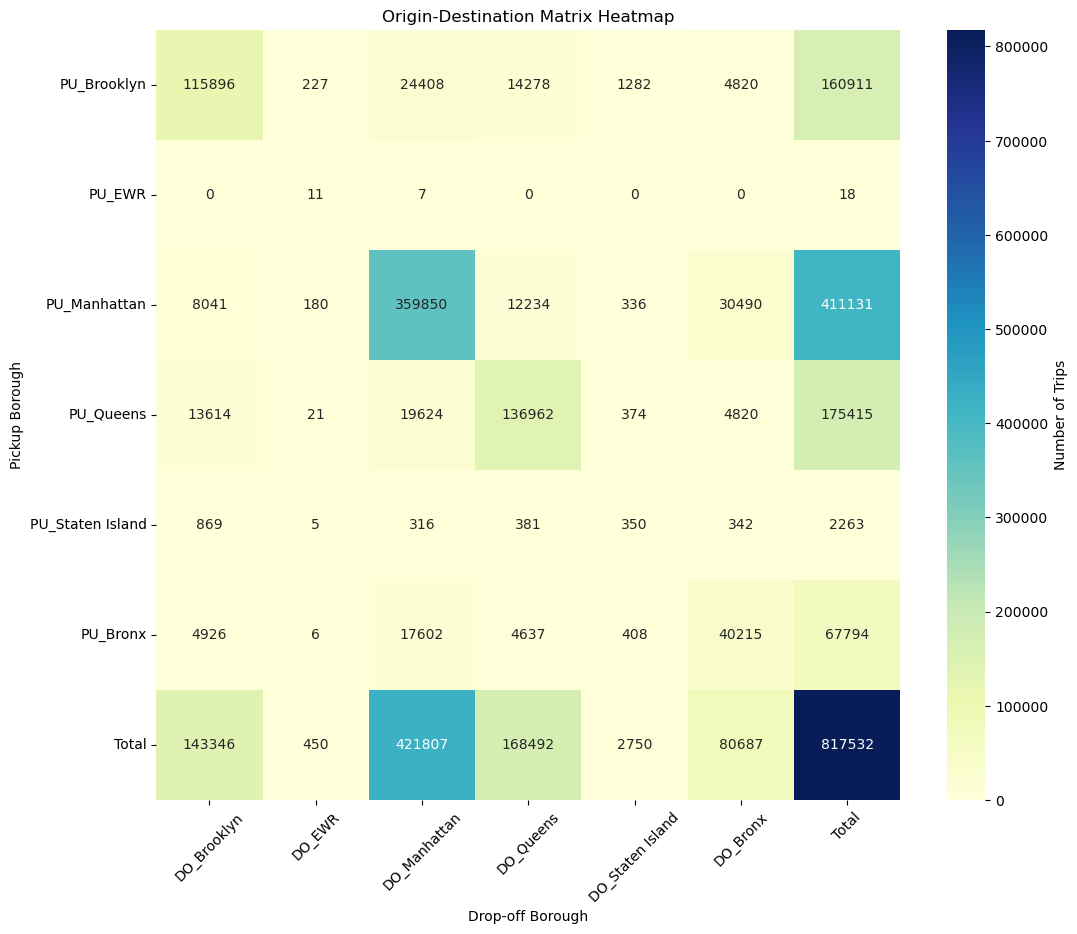

In [37]:
# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(od_matrix, cmap="YlGnBu", annot=True, fmt=".0f", cbar_kws={"label": "Number of Trips"})
plt.title("Origin-Destination Matrix Heatmap")
plt.xlabel("Drop-off Borough")
plt.ylabel("Pickup Borough")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()


In [41]:
# محاسبه OD matrix  
od_matrix = pd.DataFrame(index=df.columns[df.columns.str.startswith('PU_')],  
                         columns=df.columns[df.columns.str.startswith('DO_')]).fillna(0)  
for pu_col in df.columns[df.columns.str.startswith('PU_')]:  
    for do_col in df.columns[df.columns.str.startswith('DO_')]:  
        od_matrix.loc[pu_col, do_col] = df[(df[pu_col] == 1) & (df[do_col] == 1)].shape[0]  

# محاسبه مجموع کل سفرها  
total_trips = od_matrix.sum().sum()  # مجموع تمامی سفرها در ماتریس  

# محاسبه درصد سفرها در ماتریس  
od_matrix_percent = od_matrix.copy()  
for pu_col in od_matrix_percent.index:  
    for do_col in od_matrix_percent.columns:  
        if od_matrix_percent.loc[pu_col, do_col] > 0:  
            percent = (od_matrix_percent.loc[pu_col, do_col] / total_trips) * 100  
            od_matrix_percent.loc[pu_col, do_col] = percent  
        else:  
            od_matrix_percent.loc[pu_col, do_col] = 0  

# فیلتر کردن جفت‌های مختلف  
different_pairs = od_matrix_percent.loc[od_matrix_percent.index.str.startswith('PU_'),   
                                         od_matrix_percent.columns.str.startswith('DO_')]  

# ایجاد یک دیکشنری برای جمع‌آوری اطلاعات  
result = []  
for pu_col in different_pairs.index:  
    for do_col in different_pairs.columns:  
        # فقط جفت‌های مختلف را نگه‌دارید و بررسی کنید که PULocationID و DOLocationID متفاوت باشند  
        if pu_col != do_col:  
            percent = different_pairs.loc[pu_col, do_col]  
            count = od_matrix.loc[pu_col, do_col]  # تعداد سفرها از ماتریس اصلی  
            if percent > 0:  # تنها جفت‌های مثبت  
                result.append({  
                    'Pickup': pu_col,  
                    'Dropoff': do_col,  
                    'Percentage': percent,  
                    'Trip Count': count  
                })  

# تبدیل به DataFrame و مرتب‌سازی  
result_df = pd.DataFrame(result)  
result_df = result_df.sort_values(by='Percentage', ascending=False)  

# تغییر نام ستون‌ها برای خوانایی بهتر  
result_df.columns = ['Pickup Borough', 'Dropoff Borough', 'Percentage of Trips', 'Number of Trips']  

# نمایش جفت‌های با بیشترین درصد سفر  
print(result_df.head(10))

   Pickup Borough Dropoff Borough  Percentage of Trips  Number of Trips
10   PU_Manhattan    DO_Manhattan            44.016626           359850
17      PU_Queens       DO_Queens            16.753106           136962
0     PU_Brooklyn     DO_Brooklyn            14.176326           115896
31       PU_Bronx        DO_Bronx             4.919074            40215
13   PU_Manhattan        DO_Bronx             3.729518            30490
2     PU_Brooklyn    DO_Manhattan             2.985571            24408
16      PU_Queens    DO_Manhattan             2.400395            19624
28       PU_Bronx    DO_Manhattan             2.153066            17602
3     PU_Brooklyn       DO_Queens             1.746476            14278
14      PU_Queens     DO_Brooklyn             1.665256            13614


In [45]:
# دیکشنری برای نگه‌داری ارتباط بین نام بوره‌ها و شناسه‌هایشان  
borough_ids = {  
    'Bronx': 1,  
    'Brooklyn': 2,  
    'Manhattan': 3,  
    'Queens': 4,  
    'Staten Island': 5  
}  

# ایجاد یک دیکشنری برای جمع‌آوری اطلاعات  
result = []  
for pu_col in od_matrix_percent.index:  
    for do_col in od_matrix_percent.columns:  
        # فقط جفت‌های مختلف را نگه‌دارید و بررسی کنید که PULocationID و DOLocationID متفاوت باشند  
        if pu_col != do_col:  
            percent = od_matrix_percent.loc[pu_col, do_col]  
            count = od_matrix.loc[pu_col, do_col]  # تعداد سفرها از ماتریس اصلی  
            if percent > 0:  # تنها جفت‌های مثبت  
                pickup_borough = pu_col.split('_')[-1]  # نام بوره  
                dropoff_borough = do_col.split('_')[-1]  # نام بوره  
                result.append({  
                    'Pickup': pickup_borough,  
                    'Dropoff': dropoff_borough,  
                    'Percentage': percent,  
                    'Trip Count': count # استفاده از دیکشنری برای شناسه  
                })  

# تبدیل به DataFrame و مرتب‌سازی بر اساس درصد سفرها  
result_df = pd.DataFrame(result)  
result_df = result_df.sort_values(by='Percentage', ascending=False)  

# تغییر نام ستون‌ها برای خوانایی بهتر  
result_df.columns = ['Pickup Borough', 'Dropoff Borough', 'Percentage of Trips', 'Number of Trips']  

# نمایش جفت‌های با بیشترین درصد سفر  
print(result_df.head(10))

   Pickup Borough Dropoff Borough  Percentage of Trips  Number of Trips
10      Manhattan       Manhattan            44.016626           359850
17         Queens          Queens            16.753106           136962
0        Brooklyn        Brooklyn            14.176326           115896
31          Bronx           Bronx             4.919074            40215
13      Manhattan           Bronx             3.729518            30490
2        Brooklyn       Manhattan             2.985571            24408
16         Queens       Manhattan             2.400395            19624
28          Bronx       Manhattan             2.153066            17602
3        Brooklyn          Queens             1.746476            14278
14         Queens        Brooklyn             1.665256            13614
